In [1]:
import os
os.chdir("../LSTM")

In [2]:
from core.nn.LSTM_M2 import LSTM_M2

%load_ext autoreload
%autoreload 2

from SIR_ODE import SIR
import math
import pickle
import datetime
from numpy import array
import matplotlib.pylab as plt
import pandas as pd
import covsirphy as cs
import requests, io, json, urllib
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from itertools import cycle
import os.path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import math
from sklearn.metrics import mean_squared_error
from itertools import cycle

import seaborn as sns
sns.set()
%matplotlib inline

In [3]:
# Download datasets
data_loader = cs.DataLoader("input")
jhu_data = data_loader.jhu()
population_data = data_loader.population()
population_df = population_data.cleaned()
oxcgrt_data = data_loader.oxcgrt()


TARGET_NPI = "Stringency_index"
target_column = "Infected"

df = jhu_data.cleaned()
old_df = df.copy()


In [15]:
NPIS = [ 'Stringency_index', 'School_closing', 'Workplace_closing',
       'Gatherings_restrictions',
       'Stay_home_restrictions',
       'International_movement_restrictions',
       'Testing_policy']
# COUNTRY = "Italy"

In [5]:
# SIR_LSTM = LSTM_M2(COUNTRY)
# DELAY_START, df_params, NPI_dates, days_delay = SIR_LSTM.estimate_country(jhu_data, 
#                                                                           population_data, 
#                                                                           oxcgrt_data, 
#                                                                           TARGET_NPI)

# # train = df[df["Date"] <= DELAY_START.strftime("%Y-%m-%d")]
# # test = df[df["Date"] >= DELAY_START.strftime("%Y-%m-%d")]

# # selection = train.iloc[-1]
# # N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
# # print('Population in', COUNTRY, ":", N)

NameError: name 'COUNTRY' is not defined

In [7]:
def preprocess_data(COUNTRY):
    df = jhu_data.cleaned()
    df = df[df["Country"] == COUNTRY]
    old_df = df.copy()
    df = df[df["Province"] == "-"]
    df[df.columns[-4:]] = df[df.columns[-4:]].rolling(7).mean()
    df["New Confirmed"] = df.Confirmed.diff()
    
#     SIR_LSTM = LSTM_M2(COUNTRY)
#     DELAY_START, df_params, NPI_dates, days_delay = SIR_LSTM.estimate_country(jhu_data, 
#                                                                               population_data, 
#                                                                               oxcgrt_data, 
#                                                                               TARGET_NPI)

    train = df[df["Date"] <= DELAY_START.strftime("%Y-%m-%d")]
    test = df[df["Date"] >= DELAY_START.strftime("%Y-%m-%d")]
    
    return df, train, test

In [8]:
def calc_param(df, lockdown_dates):
    total_params = ["theta", "kappa", "rho", "sigma"]
    calc_params_df = {}
    for param in total_params:
        values = []
        for date in df["Date"].values:
            if date in lockdown_dates.values:
                values.append(np.mean(df[df['Date'] == date][param]))
        calc_params_df[param] = np.mean(values)
    return calc_params_df

def get_res_df(NPI, selection, plot=True):
    params_total = {}
    sir_params_total = {}
    for p in NPI_dates:
        res = calc_param(df_params, pd.Series(NPI_dates[p]))
        if not math.isnan(res["kappa"]):
            params_total[p] = res
            sir = SIR(N=N, I0=selection[target_column], R0=selection["Recovered"], 
                      beta=res["rho"], gamma=res["theta"], days=len(test))
            SIR_results = sir.simulate(target="Infected", plot=False)
            sir_params_total[p] = SIR_results
    test["SIR Infected" + NPI] = SIR_results["I"]

    SIR_LSTM = LSTM_M2(COUNTRY, DELAY_START, FUTURE_DAYS=len(test))
    SIR_LSTM.input_data(df)
    results = SIR_LSTM.simulate();
    
    test["LSTM"] = results["pred"]
    test["M2"] = SIR_LSTM.update_predictions(test["SIR Infected" + NPI], tau=days_delay)
    subset_old_df = old_df[old_df["Country"] == COUNTRY]
    test["Observed"] = subset_old_df[subset_old_df["Date"] >= DELAY_START.strftime("%Y-%m-%d")]["Infected"]
    
    if plot:
        train_copy = train[train["Date"] >= pd.to_datetime('2020-08-01')].copy()
        ax = train_copy.plot(x="Date", y="Infected", label="Train");
        test.plot(x="Date", y=["Infected", "SIR Infected" + NPI, "LSTM", "M2", "Observed"], ax=ax);
        ax.axvline(x=DELAY_START.strftime("%Y-%m-%d"), color="grey");
    return test

Population in United Kingdom : 66460344
3 [(82, 132), (353, 358), (360, 448)] PERIODS
2020-12-26 00:00:00
Stringency_index


 20%|██        | 1/5 [00:02<00:10,  2.67s/it]


nan
False


 20%|██        | 1/5 [00:02<00:11,  2.94s/it]


7.630282878875732
True


100%|██████████| 5/5 [00:06<00:00,  1.25s/it]


0.2550736665725708
False
School_closing


100%|██████████| 5/5 [00:06<00:00,  1.22s/it]


0.5698220729827881
False
Workplace_closing


 20%|██        | 1/5 [00:01<00:07,  1.90s/it]


nan
False


100%|██████████| 5/5 [00:05<00:00,  1.17s/it]


0.18519574403762817
False
Gatherings_restrictions


100%|██████████| 5/5 [00:07<00:00,  1.40s/it]


0.1866389513015747
False
Stay_home_restrictions


100%|██████████| 5/5 [00:03<00:00,  1.34it/s]


nan
False


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


0.24127471446990967
False
International_movement_restrictions


 20%|██        | 1/5 [00:02<00:09,  2.45s/it]


nan
False


100%|██████████| 5/5 [00:05<00:00,  1.12s/it]


0.1873406022787094
False
Testing_policy


100%|██████████| 5/5 [00:06<00:00,  1.21s/it]


0.2634725272655487
False


,RMSE,MAE,MAPE
Stringency_index,0.030846,0.017701,0.502624
School_closing,0.053773,0.006962,0.946605
Workplace_closing,0.027501,0.013691,0.448837
Gatherings_restrictions,0.017656,0.007022,0.304604
Stay_home_restrictions,0.030266,0.016914,0.493520
International_movement_restrictions,0.027786,0.013986,0.451600
Testing_policy,0.031124,0.018097,0.508500


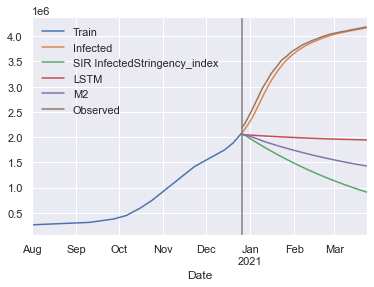

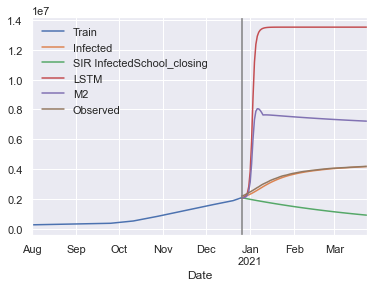

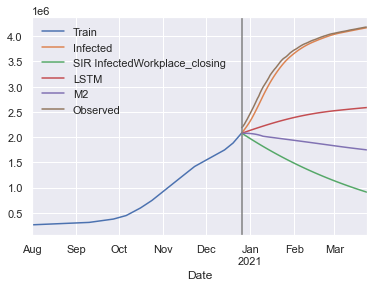

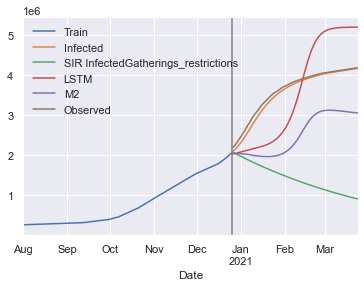

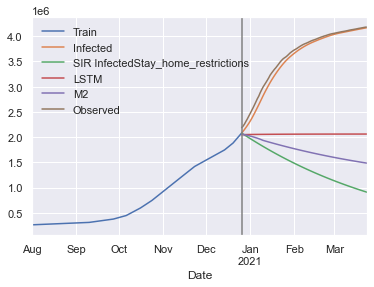

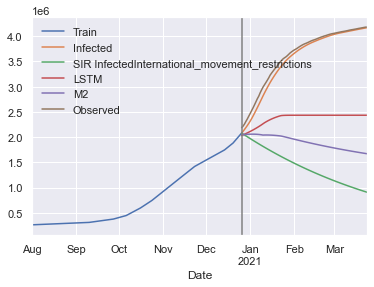

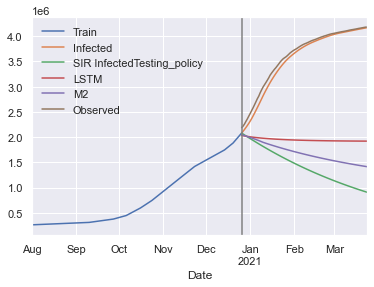

In [25]:

COUNTRIES = ["United Kingdom"]
for COUNTRY in COUNTRIES:
    SIR_LSTM = LSTM_M2(COUNTRY)

    N = population_df[population_df["Country"] == COUNTRY]["Population"].values[0]
    print('Population in', COUNTRY, ":", N)
    results = pd.DataFrame(columns = ["RMSE", "MAE", "MAPE"])
    DELAY_START, df_params, NPI_dates, days_delay = SIR_LSTM.estimate_country(jhu_data, 
                                                                          population_data, 
                                                                          oxcgrt_data, 
                                                                          NPIS[0])
    for intervention in NPIS:
        print(intervention)
        if DELAY_START is False:
            errors = pd.DataFrame(columns = ["RMSE", "MAE", "MAPE"])
            errors = errors.append(pd.Series([np.nan, np.nan, np.nan], index=errors.columns ), ignore_index=True)
            errors = errors.set_index(pd.Index([intervention]))
            results = results.append(errors)
            print("too little data", intervention)
        else:
            df, train, test = preprocess_data(COUNTRY)
            selection = train.iloc[-1]
            res_df = get_res_df(NPI=intervention, selection=selection, plot=True)
            errors = SIR_LSTM.compute_errors(N, test)
            errors = errors.set_index(pd.Index([intervention]))
            results = results.append(errors)
    display(results)
    results.to_pickle('./results/' + COUNTRY + "_errors_SIR")


In [13]:
results

,RMSE,MAE,MAPE
School_closing,0.000518,0.071143,4.452055e+00
Workplace_closing,0.000526,0.170357,1.213472e+00
Cancel_events,NaN,NaN,NaN
Gatherings_restrictions,0.000363,1.543546,2.926284e+30
Transport_closing,NaN,NaN,NaN
Stay_home_restrictions,NaN,NaN,NaN
Internal_movement_restrictions,NaN,NaN,NaN
International_movement_restrictions,0.000270,0.036718,2.777051e+31
Information_campaigns,NaN,NaN,NaN
